# Fun with language modelling

Если вы пропустили лекцию, то посмотрите слайды к ней — они где-то есть. Также полезно почитать:

* [Unreasonable effectiveness of RNN](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) (Andrej Karpathy)
* [Официальный пример от PyTorch](https://github.com/pytorch/examples/tree/master/word_language_model)

Рекомендуется заранее всё прочитать, чтобы понять, что от вас хотят. При желании, можете переписать всё так, как подсказывает ваше сердце.

---

In [3]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd

import re

import matplotlib.pyplot as plt
%matplotlib inline

## Препроцессинг (3 балла)

Возьмите какие-нибудь сырые данные. Википедия, «Гарри Поттер», «Игра Престолов», тексты Монеточки, твиты Тинькова — что угодно.

Для простоты будем делать char-level модель. Выкиньте из текстов все ненужные символы (можете оставить только алфавит и, пунктуацию). Сопоставьте всем различным символам свой номер. Удобно это хранить просто в питоновском словаре (`char2idx`). Для генерации вам потребуется ещё и обратный словарь (`idx2char`). Вы что-то такое должны были писать на вступительной — можете просто переиспользовать код оттуда.

Заранее зарезервируйте айдишники под служебные символы: `<START>`, `<END>`, `<PAD>`, `<UNK>`.

Клёво будет написать отдельный класс, который делает токенизацию и детокенизацию.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
data = pd.read_csv('/content/drive/MyDrive/labeled.csv')
data

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0
...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0


In [7]:
data = data.comment

In [8]:
class Vocab:
    def __init__(self, data):

        self.char2idx = {'<START>': 0, '<END>': 1, '<PAD>': 2, '<UNK>': 3}
        self.idx2char = {0: '<START>', 1: '<END>', 2: '<PAD>', 3: '<UNK>'}

        for comment in data:
          comment = self.preprocess(comment)
          for char in comment:
            if char not in self.char2idx:
              self.char2idx[char] = len(self.char2idx)
              self.idx2char[len(self.char2idx) - 1] = char

    def preprocess(self, text):
      text = re.sub(r'\n', '', text)
      return re.sub(r'[^а-я.,!?\s]', '', text.lower())
    
    def tokenize(self, sequence):
        # выполните какой-то базовый препроцессинг
        # например, оставьте только алфавит и пунктуацию

        return [self.char2idx[char] for char in self.preprocess(sequence)]
    
    def detokenize(self, sequence):
        return ''.join([self.idx2char[idx] for idx in sequence])
    
    def __len__(self):
        return len(self.char2idx)

In [9]:
class TextDataset():
    
    def __init__(self, data, max_len):

        # обучите вокаб
        self.vocab = Vocab(data)
        self.data = data
        self.max_len = max_len
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        sample = self.vocab.tokenize(sample)
        sample_tokenized = sample[:self.max_len + 1] if len(sample) > self.max_len else sample
        sample = sample_tokenized[1:]
        target = sample_tokenized[:-1]
        sample += ([2] * (self.max_len - len(sample)))
        target += ([2] * (self.max_len - len(target)))
        sample = torch.LongTensor(sample)# сконвертируйте в LongTensor
        target = torch.LongTensor(target)
        return sample, target

Если у вас какой-то большой массив текста (скажем, статьи Википедии), вы можете просто нарезать из него кусочки фиксированной длины и так их подавать в модель.

Если же вы хотите приключений, то можно разбить этот текст на предложения (`nltk.sent_tokenize`), и тогда все примеры будут разной длины. По соображениям производительности, вы не хотите использовать самые длинные и самые короткие сэмплы, поэтому имеет смысл обрезать их по длине.

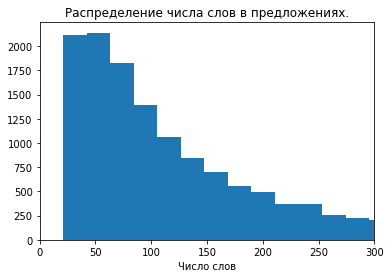

In [169]:
plt.hist([len(x) for x in data], bins=350)
plt.title('Распределение числа слов в предложениях.')
plt.xlabel('Число слов')
plt.xlim((0, 300))
plt.show()

In [10]:
min_len = 20  # предложения с меньшим количеством символов не будут рассматриваться
max_len = 130 # предложения с большим количеством символов будут обрезаться

Разобьём на обучение и валидацию:

In [11]:
dataset = TextDataset(data, max_len)

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

In [12]:
data[0]

'Верблюдов-то за что? Дебилы, бл...\n'

In [175]:
dataset[0]

(tensor([ 5,  6,  7,  8,  9, 10, 11,  4, 12, 11, 13, 14, 15, 13, 16, 12, 11, 17,
         13, 10,  5,  7, 18,  8, 19, 20, 13,  7,  8, 21, 21, 21,  2,  2,  2,  2,
          2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2]),
 tensor([ 4,  5,  6,  7,  8,  9, 10, 11,  4, 12, 11, 13, 14, 15, 13, 16, 12, 11,
         17, 13, 10,  5,  7, 18,  8, 19, 20, 13,  7,  8, 21, 21,  2,  2,  2,  2,
          2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
 

## Модель (3 балла)

Примерно такое должно зайти:

* Эмбеддинг
* LSTM / GRU
* Линейный слой
* Softmax

In [13]:
class LM(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, num_layers, dropout, tie_weights):
        super().__init__()
        
        self.encoder = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)
        self.decoder = nn.Linear(hidden_dim, input_dim)
        self.drop = nn.Dropout(dropout)
        self.softmax = nn.Softmax()
        
        if tie_weights:
            # "Using the Output Embedding to Improve Language Models" (Press & Wolf 2016)
            # https://arxiv.org/abs/1608.05859
            assert hidden_dim == embedding_dim
            self.decoder.weight = self.encoder.weight

        #self.rnn_type = rnn_type
        self.hidden_dim = hidden_dim
        self.nlayers = num_layers

    def forward(self, input, hidden):
        emb = self.drop(self.encoder(input))
        output, hidden = self.rnn(emb, hidden)
        output = self.drop(output)
        decoded = self.decoder(output.reshape(output.size(0)*output.size(1), output.size(2)))
        return decoded.view(output.size(0), output.size(1), decoded.size(1)), hidden

    def init_hidden(self, batch_size):
        # начальный хидден должен быть нулевой
        # (либо хоть какой-то константный для всего обучения)
        return torch.zeros(self.nlayers, batch_size, self.hidden_dim)

## Обучение

In [14]:
epochs = 5
lr = 1e-3 
batch_size = 64

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = LM(
    input_dim = len(dataset.vocab),
    embedding_dim = 128,
    hidden_dim = 128,
    num_layers = 10,
    dropout = 0.1,
    tie_weights= True
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train = DataLoader(train_set, batch_size=batch_size)
test = DataLoader(test_set, batch_size=batch_size)

In [15]:
train_history = []
val_history = []

for e in range(epochs):
    for x, y in train:
        model.train()
        
        optimizer.zero_grad()
        
        # 0. Распакуйте данные на нужное устройство
        x = x.to(device)
        y = y.to(device)
        # 1. Инициилизируйте hidden
        hidden = model.init_hidden(len(x)).to(device)
        # 2. Прогоните данные через модель, получите предсказания на каждом токене
        output, hidden = model(x, hidden)
        # 3. Посчитайте лосс (maxlen независимых классификаций) и сделайте backward()
        loss = criterion(output.reshape(-1, len(dataset.vocab)), y.reshape(output.shape[0] * output.shape[1]))
        loss.backward()
        # 4. Клипните градиенты -- у RNN-ок с этим часто бывают проблемы
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.2)
        # 5. Залоггируйте лосс куда-нибудь
        train_history.append(loss.item())
        optimizer.step()
    
    for x, y in test:
        model.eval()
        
        optimizer.zero_grad()
        
        x = x.to(device)
        y = y.to(device)

        hidden = model.init_hidden(len(x)).to(device)

        output, hidden = model(x, hidden)

        loss = criterion(output.reshape(-1, len(dataset.vocab)), y.reshape(output.shape[0] * output.shape[1]))

        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.2)

        val_history.append(loss.item())
        optimizer.step()


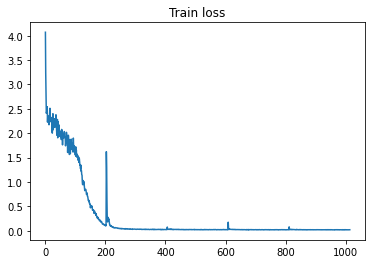

In [16]:
plt.title('Train loss')
plt.plot(train_history)
plt.show()

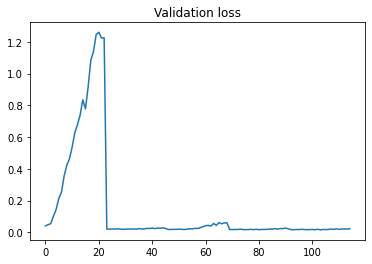

In [17]:
plt.title('Validation loss')
plt.plot(val_history)
plt.show()

## Спеллчекер (3 балла)

Из языковой модели можно сделать простенький спеллчекер: можно визуализировать лоссы на каждом символе (либо какой-нибудь другой показатель неуверенности).

Бонус: можете усреднить перплексии по словам и выделять их, а не отдельные символы.

In [23]:
from IPython.core.display import display, HTML

def print_colored(sequence, intensities, delimeter=''):
    html = delimeter.join([
        f'<span style="background: rgb({255}, {255-x}, {255-x})">{c}</span>'
        for c, x in zip(sequence, intensities) 
    ])
    display(HTML(html))

print_colored('Налейте мне экспрессо'.split(), [0, 0, 100], ' ')

sequence = 'Эту домашку нужно сдать втечении двух недель'
intensities = [0]*len(sequence)
intensities[25] = 50
intensities[26] = 60
intensities[27] = 70
intensities[31] = 150
print_colored(sequence, intensities)

In [20]:
criterion = nn.CrossEntropyLoss(reduce=False)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [36]:
def spellcheck(sequence):
    model.eval()
    
    # векторизуйте sequence; паддинги делать не нужно
    decoded_sequence = torch.LongTensor(dataset.vocab.tokenize(sequence[:-1])).reshape(1, -1).to(device)
    
    # прогоните модель и посчитайте лосс, но не усредняйте
    # с losses можно что-нибудь сделать для визуализации; например, в какую-нибудь степень возвести
    hidden = model.init_hidden(1).to(device)
    output, _ = model(decoded_sequence, hidden)
    y = torch.LongTensor(dataset.vocab.tokenize(sequence[1:])).reshape(1, -1).to(device)
    losses = criterion(output.reshape(-1, len(dataset.vocab)), y.reshape(len(sequence) - 1))
    print_colored(sequence, np.concatenate((np.array([0]), np.array(losses.detach().cpu())), axis=None))

In [37]:
sequences = ['В этом претложениии очен много очепяток.', 
             'Здесь появилась лишнняя буква.', 
             'В этом предложении все нормально.', 
             'Чтонибудь пишеться чериз дефис.', 
             'Слова нрпдзх не сущесдвует.']

for sequence in sequences:
    spellcheck(sequence)

## Генерация предложений (3 балла)

* Поддерживайте hidden state при генерации. Не пересчитывайте ничего больше одного раза.
* Прикрутите температуру: это когда при сэмплировании все логиты (то, что перед софтмаксом) делятся на какое-то число (по умолчанию 1, тогда ничего не меняется). Температура позволяет делать trade-off между разнообразием и правдоподобием (подробнее — см. блог Карпатого).
* Ваша реализация должна уметь принимать строку seed — то, с чего должно начинаться сгенерированная строка.

In [289]:
def sample(num_tokens, seed="", temperature=1.0):
    model.eval()
        
    hidden = model.init_hidden(1).to(device)
    input = torch.LongTensor(dataset.vocab.tokenize(seed)).reshape(1, -1).to(device)

    
    continuation = ''
    
    for _ in range(num_tokens):
        output, hidden = model(input, hidden)
        
        token_probas = output.squeeze().div(temperature).exp().cpu()
        token = torch.multinomial(token_probas, 1)[0]
        
        continuation += dataset.vocab.idx2char[token.item()]
        input = torch.LongTensor(dataset.vocab.tokenize(seed + continuation)).reshape(1, -1).to(device)
    
    return continuation

In [290]:
beginnings = ['Шел медведь по лесу', 
              'Встретились англичанин, американец и русский. Англичанин говорит:',
              'Так вот, однажды качки решили делать ремонт',
              'Поручик Ржевский был',
              'Идёт Будда с учениками по дороге',
              'Мюллер: Штирлиц, где вы были в 1938 году?',
              'Засылают к нам американцы шпиона под видом студента',
              'Подъезжает электричка к Долгопе:']

for beginning in beginnings:
    print(f'{beginning}... {sample(10, beginning)}')
    print()

Шел медведь по лесу... мумумумуму

Встретились англичанин, американец и русский. Англичанин говорит:... зтзтзтзтзт

Так вот, однажды качки решили делать ремонт... этэтэтэтэт

Поручик Ржевский был... илилилилил

Идёт Будда с учениками по дороге... бебебебебе

Мюллер: Штирлиц, где вы были в 1938 году?... ицицицициц

Засылают к нам американцы шпиона под видом студента... вавававава

Подъезжает электричка к Долгопе:... аеаеаеаеае

